# Understanding CMRR Multiband Calibration Scans (AdjCoilSens)

This notebook analyzes the **AdjCoilSens** (Adjust Coil Sensitivity) calibration scan that precedes CMRR multiband EPI acquisitions. The purpose of this scan is to measure coil sensitivity maps needed for parallel imaging reconstruction (GRAPPA/SENSE).

## Key Findings
- **Low resolution**: Only 32 phase encoding lines (compared to typical 64-128)
- **Large FOV**: 500×500×500mm covers entire head/body region
- **Dual coil acquisition**: Alternates between body coil (reference) and head coils
- **3D encoding**: Uses partition encoding (cPar) for 3D coverage

In [1]:
import twixtools
print('Hello')
full_sub_file_path = '/lustre/disk/home/shared/cusacklab/foundcog-raw/participants/ICC_103A/meas_MID00039_FID94271_cmrr_SBep2d_se_AP_RDS.dat'
twix_raw = twixtools.read_twix(full_sub_file_path)
epi_map  = twixtools.map_twix(twix_raw)


Hello
Software version: VD/VE (!?)

Scan  0


100%|██████████| 63.4M/63.4M [00:00<00:00, 1.65GB/s]


Scan  1


100%|██████████| 830M/830M [00:00<00:00, 995MB/s] 


Measurements: 2


## Load TWIX Raw Data

Using `twixtools` to read Siemens raw MRI data (.dat file). This file contains two measurements:
1. **AdjCoilSens calibration scan** (twix_raw[0])
2. **Main EPI acquisition** (twix_raw[1])

In [32]:
# See name of files
import json
# print(json.dumps(twix_raw[1]['hdr'], indent=2))
print(twix_raw[0]['raidfile_hdr'])
print(twix_raw[1]['raidfile_hdr'])
#print(epi_map[0])

(38, 94270, 10240, 67503200, b'xxxxxxxxxxxxxxxxxxxxxxx', b'AdjCoilSens')
(39, 94271, 67513856, 871717312, b'xxxxxxxxxxxxxxxxxxxxxxx', b'cmrr_SBep2d_se_AP_RDS')


## Extract Acquisition Parameters

The TWIX header contains detailed acquisition parameters. Here we extract:
- **Field of View (FOV)**: Physical dimensions of the imaging volume
- **Voxel size**: Resolution in each dimension
- **Matrix size**: Number of k-space points

These parameters are stored in `MeasYaps` (Measurement Parameters) section of the header.

In [3]:
# Get voxel size and FOV from the first twix image
hdr = twix_raw[0]['hdr']

# Look for slice information
slice_array = hdr['MeasYaps']['sSliceArray']
print("Slice Array Keys:", slice_array.keys())

print(slice_array)
# Get slice information
if 'asSlice' in slice_array:
    first_slice = slice_array['asSlice'][0]
    print("\nFirst Slice Info:")
    print("Keys:", first_slice.keys())
    
    # Read out FOV
    if 'dReadoutFOV' in first_slice:
        print(f"\nReadout FOV: {first_slice['dReadoutFOV']} mm")
    if 'dPhaseFOV' in first_slice:
        print(f"Phase FOV: {first_slice['dPhaseFOV']} mm")
    if 'dThickness' in first_slice:
        print(f"Slice Thickness: {first_slice['dThickness']} mm")

# Get k-space parameters
kspace = hdr['MeasYaps']['sKSpace']
print("\n\nK-Space Info:")
if 'lBaseResolution' in kspace:
    print(f"Base Resolution: {kspace['lBaseResolution']}")
if 'lPhaseEncodingLines' in kspace:
    print(f"Phase Encoding Lines: {kspace['lPhaseEncodingLines']}")

# Calculate voxel size
base_res = kspace.get('lBaseResolution', None)
phase_lines = kspace.get('lPhaseEncodingLines', None)
readout_fov = first_slice.get('dReadoutFOV', None)
phase_fov = first_slice.get('dPhaseFOV', None)
thickness = first_slice.get('dThickness', None)

if base_res and phase_lines and readout_fov and phase_fov and thickness:
    voxel_size_x = readout_fov / base_res
    voxel_size_y = phase_fov / phase_lines
    voxel_size_z = thickness
    print(f"\nCalculated Voxel Size:")
    print(f"  X (readout): {voxel_size_x:.3f} mm")
    print(f"  Y (phase): {voxel_size_y:.3f} mm")
    print(f"  Z (slice): {voxel_size_z:.3f} mm")

Slice Array Keys: dict_keys(['lSize', 'lConc', 'ucMode', 'ucAnatomicalSliceMode', 'asSlice', 'sTSat'])
{'lSize': 1, 'lConc': 1, 'ucMode': 4, 'ucAnatomicalSliceMode': 4, 'asSlice': [{'dThickness': 499.84, 'dPhaseFOV': 500.0, 'dReadoutFOV': 500.0, 'sNormal': {'dTra': 1.0}}], 'sTSat': {'dThickness': 50.0, 'ulShape': 1}}

First Slice Info:
Keys: dict_keys(['dThickness', 'dPhaseFOV', 'dReadoutFOV', 'sNormal'])

Readout FOV: 500.0 mm
Phase FOV: 500.0 mm
Slice Thickness: 499.84 mm


K-Space Info:
Base Resolution: 64
Phase Encoding Lines: 32

Calculated Voxel Size:
  X (readout): 7.812 mm
  Y (phase): 15.625 mm
  Z (slice): 499.840 mm


## Explore Measurement Data Buffers (MDBs)

Each MDB entry contains:
- **Raw k-space data**: Complex values for each channel
- **Counters**: Line (cLin), Partition (cPar), Slice (cSlc), etc.
- **Flags**: Indicate data type (image, noise, phase correction, etc.)
- **CoilSelect**: Identifies which coil group acquired this data (0=head, 1=body)

In [10]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix_raw[0]['mdb'] if mdb.is_image_scan()]
hdr = twix_raw[0]['hdr']

print(f"Total image MDbs: {len(image_mdbs)}\n")

# Check the first 21 entries that have cLin=1
print("Comparing first 21 MDB entries with cLin=1:\n")
print("="*80)

for i in range(21):
    if i < len(image_mdbs):
        mdb = image_mdbs[i]
        print(f"\nMDB {i}:")
        print(f"  cLin={mdb.cLin}, cSlc={mdb.cSlc}, cRep={mdb.cRep}, cSet={mdb.cSet}, cPar={mdb.cPar}")
        print(f"  cEco={mdb.cEco}, cPhs={mdb.cPhs}, cSeg={mdb.cSeg}, cAve={mdb.cAve}")
        print(f"  CoilSelect: {mdb.mdh.CoilSelect if hasattr(mdb.mdh, 'CoilSelect') else 'N/A'}")
        print(f"  Number of channels: {len(mdb.channel_hdr)}")
        
        # Check data shape
        if hasattr(mdb.data, 'shape'):
            print(f"  Data shape: {mdb.data.shape}")
        
        # Get active flags
        flags = mdb.get_active_flags()
        if flags:
            print(f"  Active flags: {flags}")

Total image MDbs: 1585

Comparing first 21 MDB entries with cLin=1:


MDB 0:
  cLin=1, cSlc=0, cRep=0, cSet=0, cPar=21
  cEco=0, cPhs=0, cSeg=0, cAve=0
  CoilSelect: 0
  Number of channels: 34
  Data shape: (34, 128)
  Active flags: ['ONLINE', 'RAWDATACORRECTION', 'FIRSTSCANINSLICE']

MDB 1:
  cLin=1, cSlc=0, cRep=0, cSet=1, cPar=21
  cEco=0, cPhs=0, cSeg=0, cAve=0
  CoilSelect: 1
  Number of channels: 2
  Data shape: (2, 128)
  Active flags: ['ONLINE', 'RAWDATACORRECTION', 'FIRSTSCANINSLICE']

MDB 2:
  cLin=1, cSlc=0, cRep=0, cSet=0, cPar=20
  cEco=0, cPhs=0, cSeg=0, cAve=0
  CoilSelect: 0
  Number of channels: 34
  Data shape: (34, 128)
  Active flags: ['ONLINE', 'RAWDATACORRECTION']

MDB 3:
  cLin=1, cSlc=0, cRep=0, cSet=1, cPar=20
  cEco=0, cPhs=0, cSeg=0, cAve=0
  CoilSelect: 1
  Number of channels: 2
  Data shape: (2, 128)
  Active flags: ['ONLINE', 'RAWDATACORRECTION']

MDB 4:
  cLin=1, cSlc=0, cRep=0, cSet=0, cPar=19
  cEco=0, cPhs=0, cSeg=0, cAve=0
  CoilSelect: 0
  Number of 

## Understanding Data Organization

**Key finding**: The data is organized by:
1. **cPar (Partition counter)**: Represents 3D encoding dimension (32 partitions)
2. **cLin (Line counter)**: Phase encoding lines (32 lines)
3. **CoilSelect**: Alternates between body coil (1) and head coils (0)

The acquisition pattern: For each partition, it acquires all lines with body coil, then repeats with head coils.

In [14]:
# Investigate cPar - Partition counter
# In MRI, partitions typically refer to the 3rd dimension in 3D encoding

print("Checking kSpace parameters for partition info:")
kspace = hdr['MeasYaps']['sKSpace']
for key in kspace.keys():
    if 'part' in key.lower() or 'Par' in key or '3d' in key.lower():
        print(f"  {key}: {kspace[key]}")

print("\n" + "="*80)
print("\nAnalyzing cPar values in first 21 MDbs:")
print(f"{'MDB':<6} {'cLin':<6} {'cPar':<6} {'cSlc':<6} {'CoilSelect':<12}")
print("-" * 50)
par_values = []
for i in range(100):
    if i < len(image_mdbs):
        mdb = image_mdbs[i]
        par_values.append(mdb.cPar)
        coil = mdb.mdh.CoilSelect if hasattr(mdb.mdh, 'CoilSelect') else 'N/A'
        print(f"{i:<6} {mdb.cLin:<6} {mdb.cPar:<6} {mdb.cSlc:<6} {coil:<12}")
        
print(f"\nUnique cPar values: {sorted(set(par_values))}")
print(f"\n** Interpretation **")
print(f"cPar (partition counter) represents different 'partitions'.")
print(f"In this calibration scan, cPar seems to cycle through slice groups.")
print(f"Combined with alternating CoilSelect (body/head), this gives")
print(f"both coil types for each slice/partition.")

Checking kSpace parameters for partition info:
  dSeqPhasePartialFourierForSNR: 1.0
  lPartitions: 32
  ucPhasePartialFourier: 16
  ucSlicePartialFourier: 16
  ucReadoutPartialFourier: 16


Analyzing cPar values in first 21 MDbs:
MDB    cLin   cPar   cSlc   CoilSelect  
--------------------------------------------------
0      1      21     0      0           
1      1      21     0      1           
2      1      20     0      0           
3      1      20     0      1           
4      1      19     0      0           
5      1      19     0      1           
6      1      18     0      0           
7      1      18     0      1           
8      1      17     0      0           
9      1      17     0      1           
10     1      16     0      0           
11     1      16     0      1           
12     1      15     0      0           
13     1      15     0      1           
14     1      14     0      0           
15     1      14     0      1           
16     1      13     0

## Build 3D K-space Arrays

Now we separate the data by coil type and organize into 3D k-space arrays:

**Head coils**: (32 partitions, 32 lines, 34 channels, 128 readout points)
**Body coils**: (32 partitions, 32 lines, 2 channels, 128 readout points)

This allows us to reconstruct images for each coil type separately.

In [15]:
# Create 3D k-space arrays for each coil set and reconstruct
import numpy as np
from numpy.fft import fftshift, ifftshift, ifftn, fftn

# Get all image MDbs
image_mdbs = [mdb for mdb in twix_raw[0]['mdb'] if mdb.is_image_scan()]

# Determine dimensions
n_lin = 1 + max([mdb.cLin for mdb in image_mdbs])
n_par = 1 + max([mdb.cPar for mdb in image_mdbs])

# Get number of readout points from first mdb
n_col = image_mdbs[0].data.shape[1]

print(f"K-space dimensions:")
print(f"  Lines (cLin): {n_lin}")
print(f"  Partitions (cPar): {n_par}")
print(f"  Readout points: {n_col}")

# Separate by CoilSelect
coil_sets = {}
for mdb in image_mdbs:
    coil_select = mdb.mdh.CoilSelect if hasattr(mdb.mdh, 'CoilSelect') else 0
    
    if coil_select not in coil_sets:
        n_channels = len(mdb.channel_hdr)
        coil_sets[coil_select] = {
            'n_channels': n_channels,
            'kspace': np.zeros([n_par, n_lin, n_channels, n_col], dtype=np.complex64),
            'name': 'HeadNeck_64' if coil_select == 0 else 'Body'
        }
    
    # Fill k-space: [partition, line, channel, readout]
    coil_sets[coil_select]['kspace'][mdb.cPar, mdb.cLin, :, :] = mdb.data

print(f"\nCoil sets found: {list(coil_sets.keys())}")
for coil_select, data in coil_sets.items():
    print(f"  CoilSelect {coil_select} ({data['name']}): {data['n_channels']} channels")
    print(f"    K-space shape: {data['kspace'].shape}")

# Store for later use
kspace_head = coil_sets[0]['kspace']
kspace_body = coil_sets[1]['kspace']

print(f"\nHead coil k-space: {kspace_head.shape}")
print(f"Body coil k-space: {kspace_body.shape}")

K-space dimensions:
  Lines (cLin): 32
  Partitions (cPar): 32
  Readout points: 128

Coil sets found: [0, 1]
  CoilSelect 0 (HeadNeck_64): 34 channels
    K-space shape: (32, 32, 34, 128)
  CoilSelect 1 (Body): 2 channels
    K-space shape: (32, 32, 2, 128)

Head coil k-space: (32, 32, 34, 128)
Body coil k-space: (32, 32, 2, 128)

Coil sets found: [0, 1]
  CoilSelect 0 (HeadNeck_64): 34 channels
    K-space shape: (32, 32, 34, 128)
  CoilSelect 1 (Body): 2 channels
    K-space shape: (32, 32, 2, 128)

Head coil k-space: (32, 32, 34, 128)
Body coil k-space: (32, 32, 2, 128)


## 3D Image Reconstruction

Reconstruction process:
1. **3D inverse FFT**: Transform k-space → image space (ifft3d function)
2. **RMS coil combination**: Combine multiple coil channels into single image
   - Formula: $\text{RMS} = \sqrt{\sum_{i=1}^{N} |S_i|^2}$
   - Where $S_i$ is the signal from coil $i$

The result shows orthogonal views (sagittal, coronal, axial) for both head and body coils.

Reconstructing head coil images...
Head coil combined image shape: (32, 32, 128)
Reconstructing body coil images...
Body coil combined image shape: (32, 32, 128)
Actual voxel sizes in image space:
  x (partition): 15.625 mm
  y (line): 15.625 mm
  z (readout): 3.905 mm


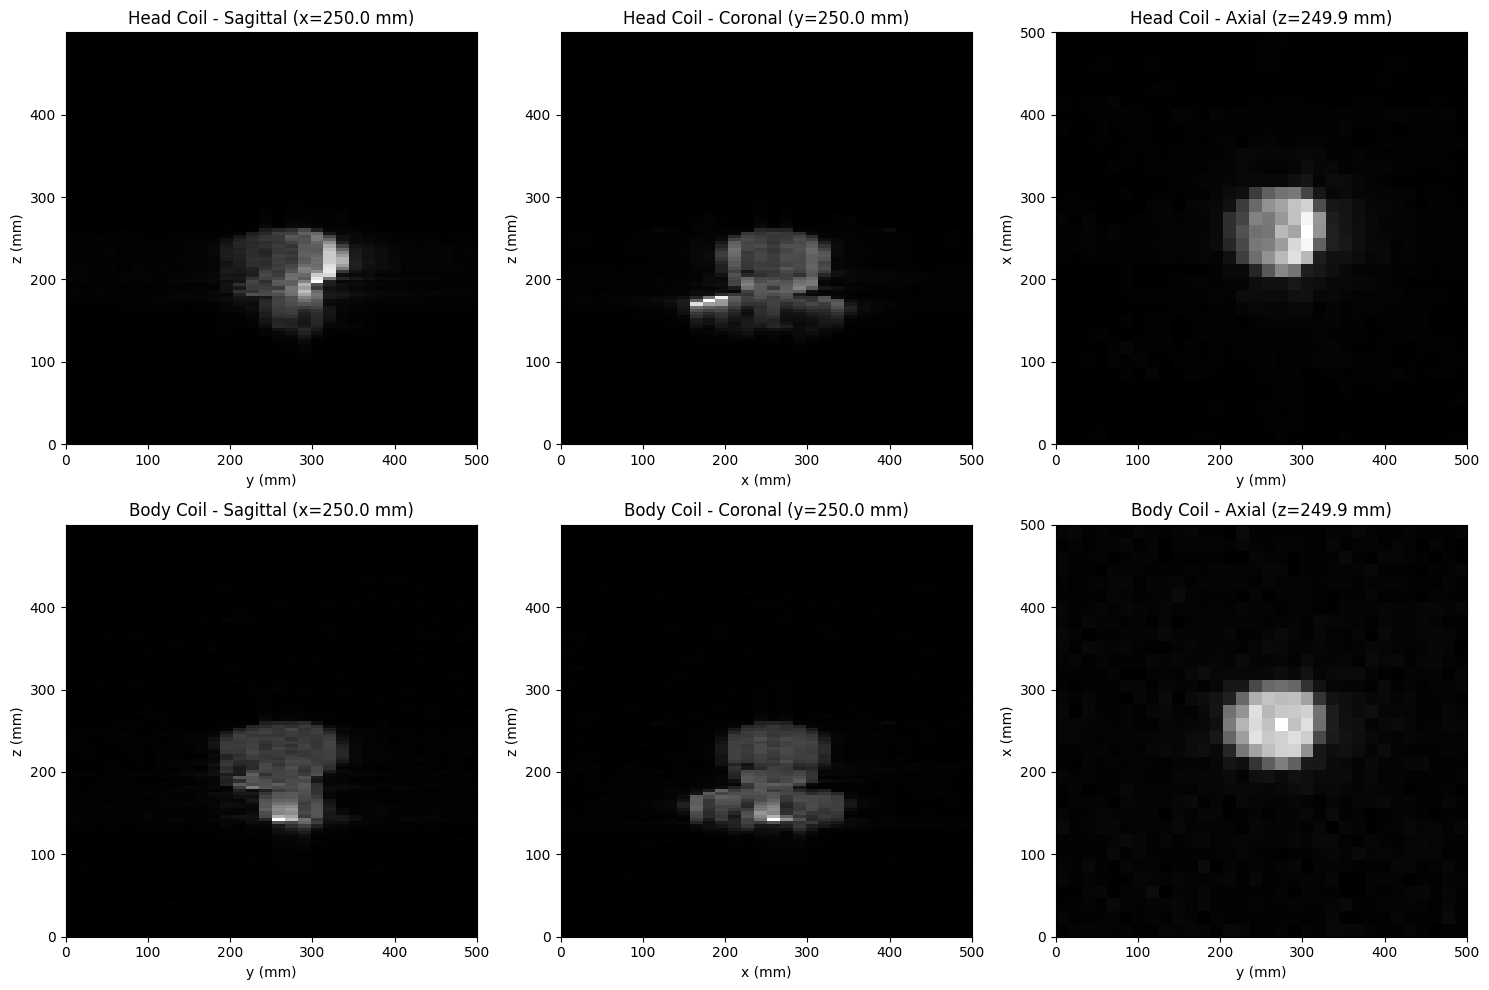


Reconstruction complete!


In [29]:
# Reconstruct images from k-space for each coil
from matplotlib import pyplot as plt

def ifft3d(kspace):
    """3D inverse FFT for image reconstruction"""
    # FFT over partition, line, and readout dimensions
    img = fftshift(ifftn(ifftshift(kspace, axes=(0, 1, 3)), axes=(0, 1, 3)), axes=(0, 1, 3))
    # Normalize
    img *= np.sqrt(np.prod(np.take(img.shape, (0, 1, 3))))
    return img

def rms_comb(sig, axis=2):
    """RMS combination across coils"""
    return np.sqrt(np.sum(np.abs(sig)**2, axis=axis))

# Reconstruct head coil images
print("Reconstructing head coil images...")
img_head_per_coil = ifft3d(kspace_head)  # Shape: (32, 32, 34, 128)
img_head_combined = rms_comb(img_head_per_coil, axis=2)  # Shape: (32, 32, 128)
print(f"Head coil combined image shape: {img_head_combined.shape}")

# Reconstruct body coil images  
print("Reconstructing body coil images...")
img_body_per_coil = ifft3d(kspace_body)  # Shape: (32, 32, 2, 128)
img_body_combined = rms_comb(img_body_per_coil, axis=2)  # Shape: (32, 32, 128)
print(f"Body coil combined image shape: {img_body_combined.shape}")

# Calculate voxel sizes for proper aspect ratios
# voxel_size_x (readout), voxel_size_y (phase), voxel_size_z (slice/partition) 
# were calculated earlier from header
# Image dimensions: [partition, line, readout] = [32, 32, 128]

# Use the actual FOV values from the header (all 500mm for this calibration scan)
fov_x = readout_fov  # 500mm - partition direction (was called readout in k-space)
fov_y = phase_fov    # 500mm - phase/line direction
fov_z = thickness    # 500mm - this is the FOV in the 3rd dimension

# Recalculate actual voxel sizes based on FOV and actual matrix dimensions
n_partition, n_line, n_readout = img_head_combined.shape  # [32, 32, 128]
actual_voxel_x = fov_x / n_partition  # 500/32 = 15.625 mm
actual_voxel_y = fov_y / n_line       # 500/32 = 15.625 mm  
actual_voxel_z = fov_z / n_readout    # 500/128 = 3.906 mm

print(f"Actual voxel sizes in image space:")
print(f"  x (partition): {actual_voxel_x:.3f} mm")
print(f"  y (line): {actual_voxel_y:.3f} mm")
print(f"  z (readout): {actual_voxel_z:.3f} mm")

# Visualize middle slices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Head coil
partition_mid = img_head_combined.shape[0] // 2
line_mid = img_head_combined.shape[1] // 2
readout_mid = img_head_combined.shape[2] // 2

# Sagittal view: slice at x position, showing (y, z)
# After transpose: display as (z, y) with extent in mm
axes[0, 0].imshow(np.abs(img_head_combined[partition_mid, :, :]).T, cmap='gray', 
                  origin='lower', extent=[0, fov_y, 0, fov_z], aspect='auto')
axes[0, 0].set_title(f'Head Coil - Sagittal (x={partition_mid*actual_voxel_x:.1f} mm)')
axes[0, 0].set_xlabel('y (mm)')
axes[0, 0].set_ylabel('z (mm)')

# Coronal view: slice at y position, showing (x, z)
# After transpose: display as (z, x) with extent in mm
axes[0, 1].imshow(np.abs(img_head_combined[:, line_mid, :]).T, cmap='gray', 
                  origin='lower', extent=[0, fov_x, 0, fov_z], aspect='auto')
axes[0, 1].set_title(f'Head Coil - Coronal (y={line_mid*actual_voxel_y:.1f} mm)')
axes[0, 1].set_xlabel('x (mm)')
axes[0, 1].set_ylabel('z (mm)')

# Axial view: slice at z position, showing (x, y)
# Display as is: x=line (y), y=partition (x) with extent in mm
axes[0, 2].imshow(np.abs(img_head_combined[:, :, readout_mid]), cmap='gray', 
                  origin='lower', extent=[0, fov_y, 0, fov_x], aspect='auto')
axes[0, 2].set_title(f'Head Coil - Axial (z={readout_mid*actual_voxel_z:.1f} mm)')
axes[0, 2].set_xlabel('y (mm)')
axes[0, 2].set_ylabel('x (mm)')

# Body coil - same orientations and aspect ratios
axes[1, 0].imshow(np.abs(img_body_combined[partition_mid, :, :]).T, cmap='gray', 
                  origin='lower', extent=[0, fov_y, 0, fov_z], aspect='auto')
axes[1, 0].set_title(f'Body Coil - Sagittal (x={partition_mid*actual_voxel_x:.1f} mm)')
axes[1, 0].set_xlabel('y (mm)')
axes[1, 0].set_ylabel('z (mm)')

axes[1, 1].imshow(np.abs(img_body_combined[:, line_mid, :]).T, cmap='gray', 
                  origin='lower', extent=[0, fov_x, 0, fov_z], aspect='auto')
axes[1, 1].set_title(f'Body Coil - Coronal (y={line_mid*actual_voxel_y:.1f} mm)')
axes[1, 1].set_xlabel('x (mm)')
axes[1, 1].set_ylabel('z (mm)')

axes[1, 2].imshow(np.abs(img_body_combined[:, :, readout_mid]), cmap='gray', 
                  origin='lower', extent=[0, fov_y, 0, fov_x], aspect='auto')
axes[1, 2].set_title(f'Body Coil - Axial (z={readout_mid*actual_voxel_z:.1f} mm)')
axes[1, 2].set_xlabel('y (mm)')
axes[1, 2].set_ylabel('x (mm)')

plt.tight_layout()
plt.show()

print("\nReconstruction complete!")

## Visualize Individual Head Coils

Each of the 34 head coil elements has its own spatial sensitivity pattern. Viewing individual coils shows:
- **Spatial localization**: Each coil is sensitive to different regions
- **Anatomy visible**: Because we haven't normalized yet, underlying anatomy is present
- **Different intensities**: Coils closer to tissue have stronger signal

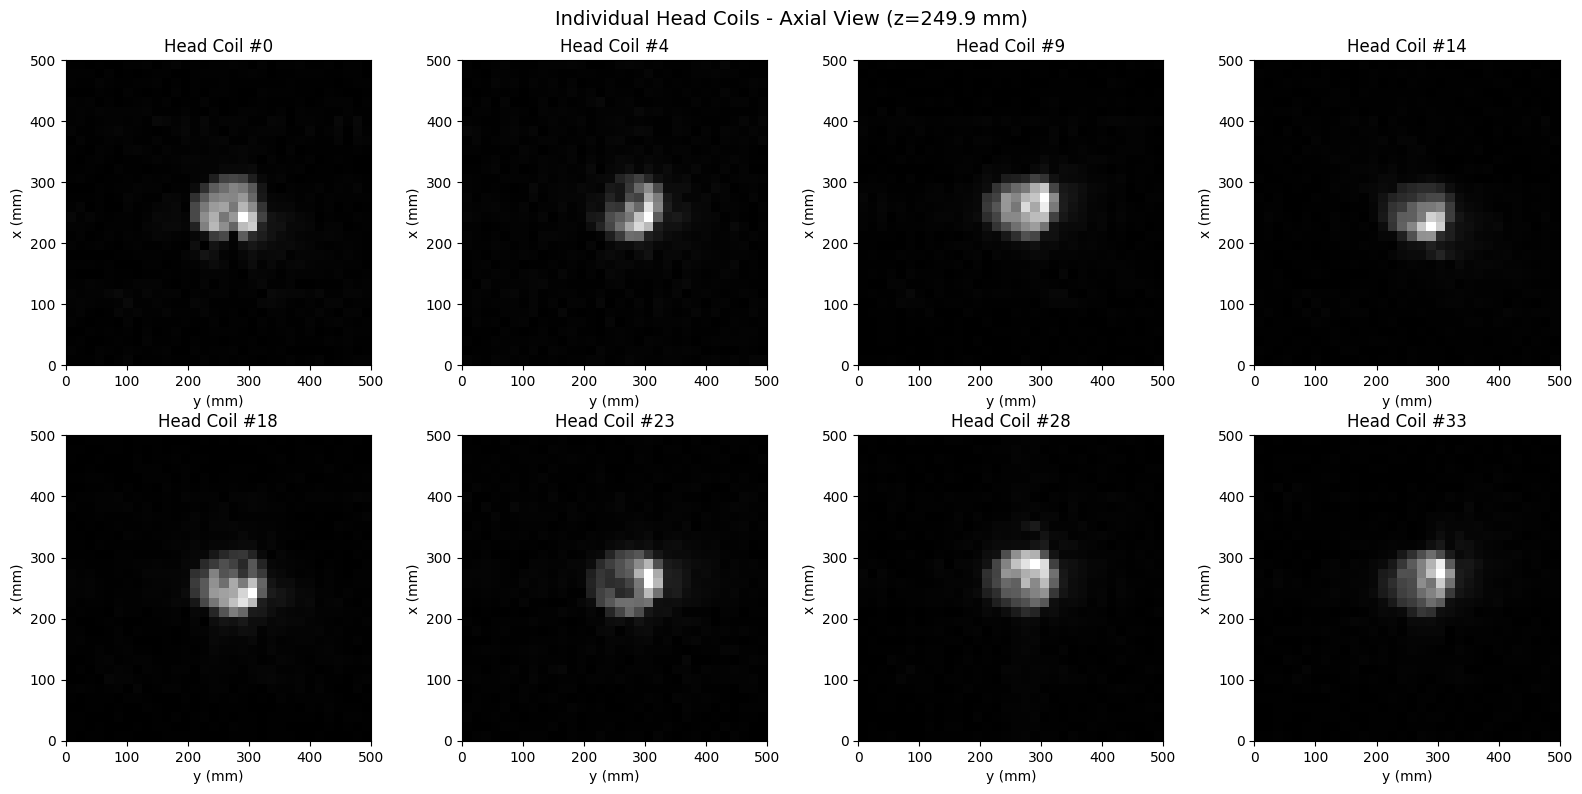

In [30]:
# Visualize individual head coils (axial view)
# Show a selection of the 34 head coils

n_coils_to_show = 8
coil_indices = np.linspace(0, 33, n_coils_to_show, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, coil_idx in enumerate(coil_indices):
    # Get axial slice (partition, line) for this coil at middle z position
    img_slice = np.abs(img_head_per_coil[:, :, coil_idx, readout_mid])
    
    axes[i].imshow(img_slice, cmap='gray', origin='lower', extent=[0, fov_y, 0, fov_x])
    axes[i].set_title(f'Head Coil #{coil_idx}')
    axes[i].set_xlabel('y (mm)')
    axes[i].set_ylabel('x (mm)')

plt.suptitle(f'Individual Head Coils - Axial View (z={readout_mid*actual_voxel_z:.1f} mm)', fontsize=14)
plt.tight_layout()
plt.show()

## Compute Normalized Coil Sensitivity Maps

**Why normalize by body coil?**
- Body coil provides relatively uniform reference across the FOV
- Division removes underlying anatomy, leaving only coil sensitivity profile
- Formula: $S_i = \frac{H_i}{B}$ where $H_i$ is head coil $i$ and $B$ is body coil

**Key steps:**
1. Create mask to avoid division by near-zero values
2. Divide each head coil image by body coil reference
3. Result: Pure spatial sensitivity profiles

These maps are essential for parallel imaging (GRAPPA/SENSE) - they encode how each coil "sees" space differently, allowing reconstruction of undersampled data.

Sensitivity maps shape: (32, 32, 34, 128)
Mask covers 6.7% of voxels


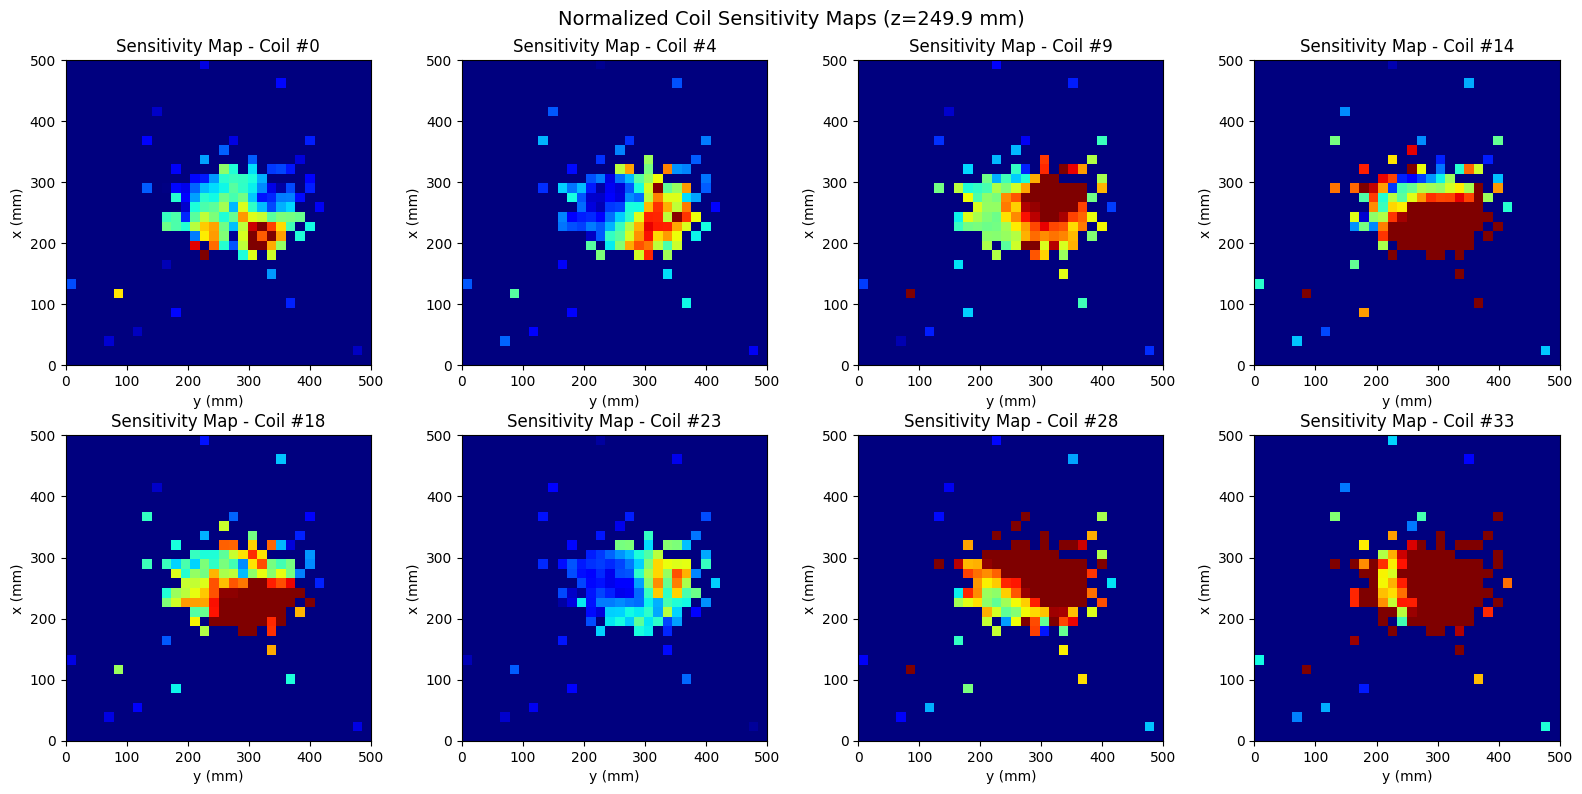

In [31]:
# Compute coil sensitivity maps by normalizing with body coil
# The body coil provides a relatively uniform reference

# Use body coil combined as the reference
body_reference = np.abs(img_body_combined)

# Create a mask to avoid division by zero in low-signal regions
# Use a threshold based on a percentage of the maximum signal
# Lower threshold for better coverage since body coil has weak signal
threshold = 0.01 * np.max(body_reference)
mask = body_reference > threshold

# Compute sensitivity maps for each head coil
# Shape: (32 partitions, 32 lines, 34 coils, 128 readout)
sensitivity_maps = np.zeros_like(img_head_per_coil, dtype=np.complex64)

# Expand body reference to match head coil dimensions
# From (32, 32, 128) to (32, 32, 1, 128) so it broadcasts correctly
body_ref_expanded = body_reference[:, :, np.newaxis, :]
mask_expanded = mask[:, :, np.newaxis, :]

# Normalize all coils at once by the body coil reference
sensitivity_maps = np.where(
    mask_expanded,
    img_head_per_coil / (body_ref_expanded + 1e-10),
    0
)

print(f"Sensitivity maps shape: {sensitivity_maps.shape}")
print(f"Mask covers {np.sum(mask) / mask.size * 100:.1f}% of voxels")

# Visualize the normalized sensitivity maps for the same coils as before
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, coil_idx in enumerate(coil_indices):
    # Get axial slice for this coil at middle z position
    sens_slice = np.abs(sensitivity_maps[:, :, coil_idx, readout_mid])
    
    axes[i].imshow(sens_slice, cmap='jet', origin='lower', vmin=0, vmax=2, extent=[0, fov_y, 0, fov_x])
    axes[i].set_title(f'Sensitivity Map - Coil #{coil_idx}')
    axes[i].set_xlabel('y (mm)')
    axes[i].set_ylabel('x (mm)')

plt.suptitle(f'Normalized Coil Sensitivity Maps (z={readout_mid*actual_voxel_z:.1f} mm)', fontsize=14)
plt.tight_layout()
plt.show()